# Table Of Content
***
1. [Exploratory Data Analysis](#eda)
2. [Experiment and Metrics Design](#metrics)
3. [Predictive Modeling](#modeling)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. EDA <a name="eda"> </a>
***
Let's load the data and get the basic information.

In [3]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [5]:
df.shape

(93142, 1)

In [6]:
df.isnull().sum()/len(df)*100

login_time    0.0
dtype: float64

The data has one column with 93,142 entries. There are no missing values and the datatype is datetime. 

In [7]:
df['count'] = 1

In [8]:
df.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


Now let's extract the time and set it as a column to be able to count the login times. The let's plot it and analyze the results.

Text(0,0.5,'Count')

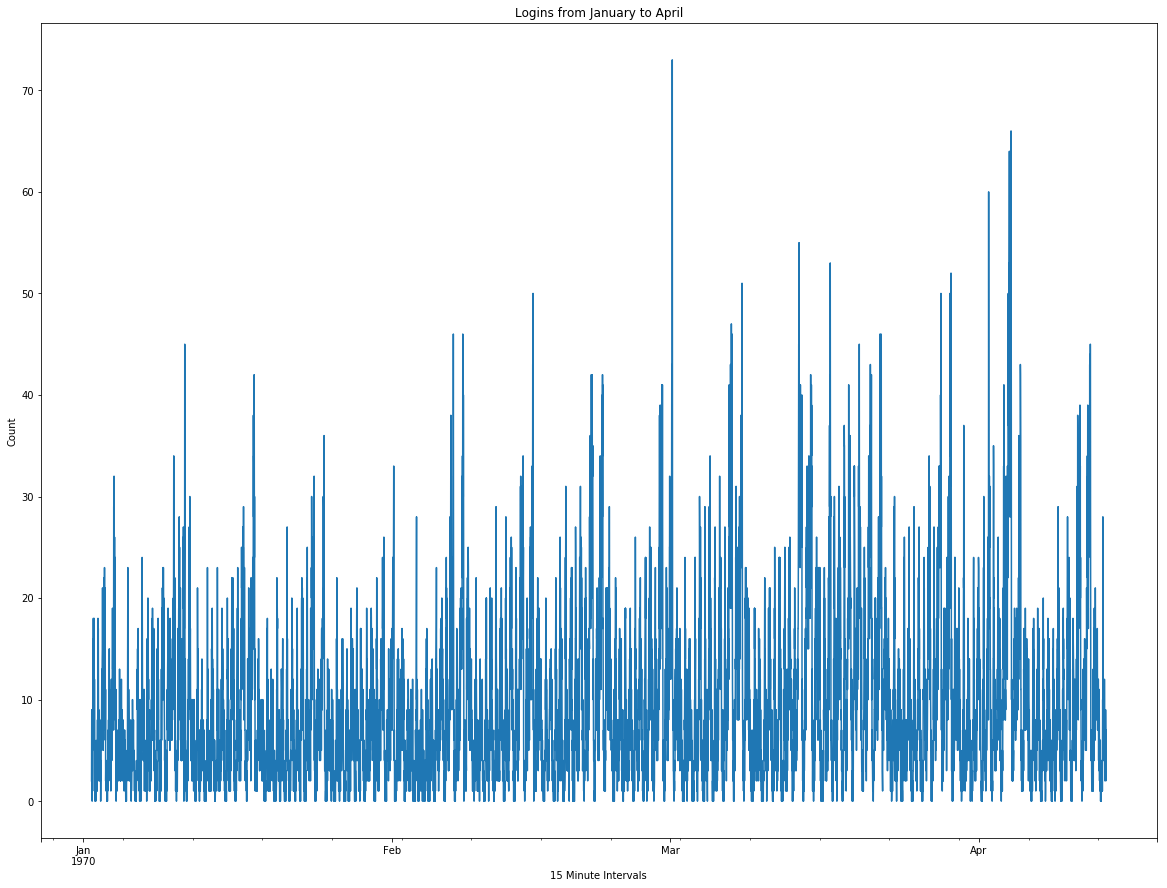

In [9]:
plt.figure(figsize=(20,15))
df.set_index('login_time').resample('15min').count()['count'].plot()
plt.title('Logins from January to April')
plt.xlabel('15 Minute Intervals')
plt.ylabel('Count')

The graph is distributed from January to April of 1970. The highest amount of logins in a 15 minute interval was a bit more than 70 in one day and the minimum was 0. However, it's kind of complicated to draw more conclusions. So let's see what happens in 15 minute intervals per hour.

Text(0,0.5,'count')

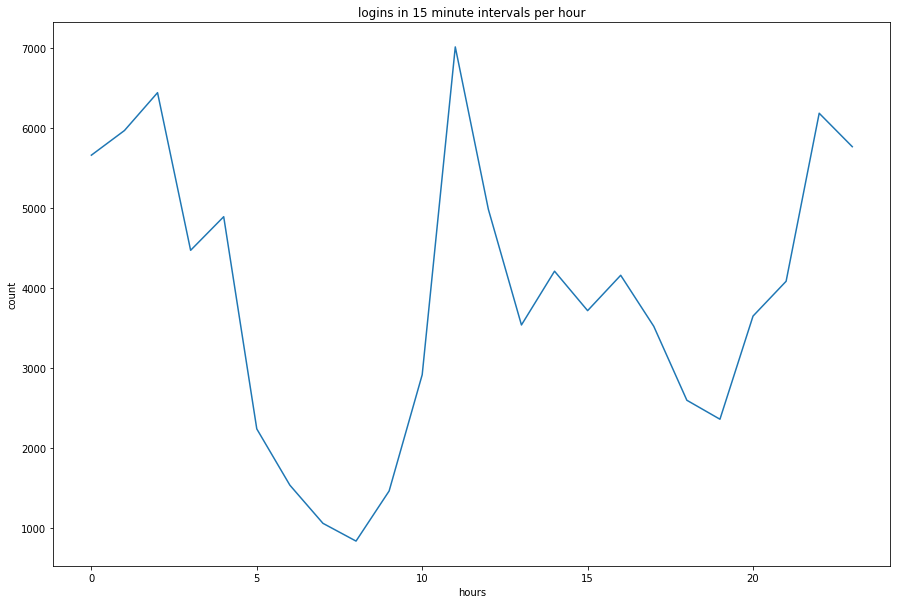

In [10]:
a = df.set_index('login_time').resample('15min').count()
plt.figure(figsize=(15,10))
a.reset_index().groupby([df['login_time'].dt.hour]).sum()['count'].plot()
plt.title('logins in 15 minute intervals per hour')
plt.xlabel('hours')
plt.ylabel('count')

- Afternoon user start login in and peak during the day.
- During the morning, users do not login as much.
- Users are active to late hours. 

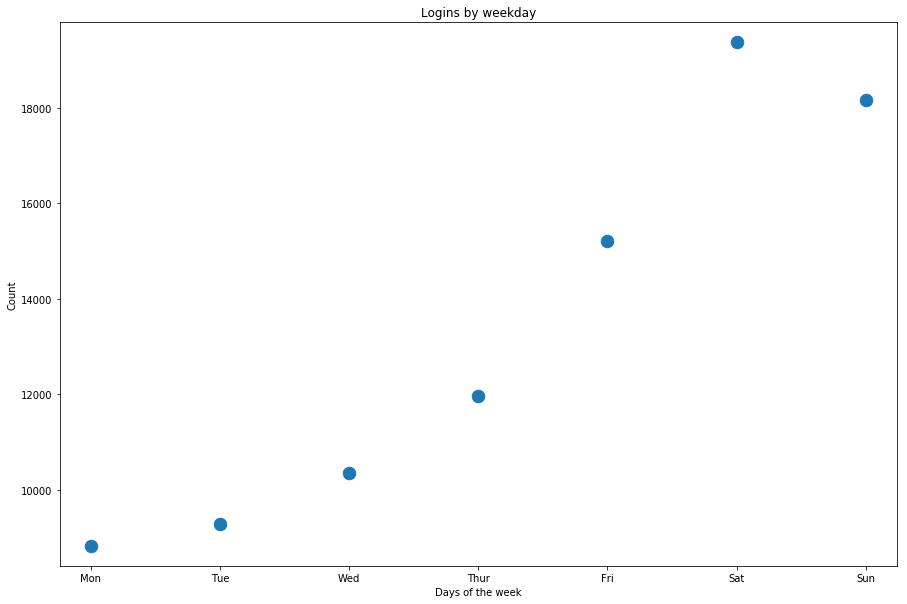

In [11]:
plt.figure(figsize=(15,10))
w = df['login_time'].dt.weekday.value_counts().sort_index()
ax = w.plot(marker='.',linestyle='none',markersize=25,visible=True)
ax.set_xticklabels(['','Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
plt.title('Logins by weekday')
plt.xlabel('Days of the week')
plt.ylabel('Count')
plt.margins(0.04)

Monday had the least amount of logins and gradually increased until it peaked on Saturday.  

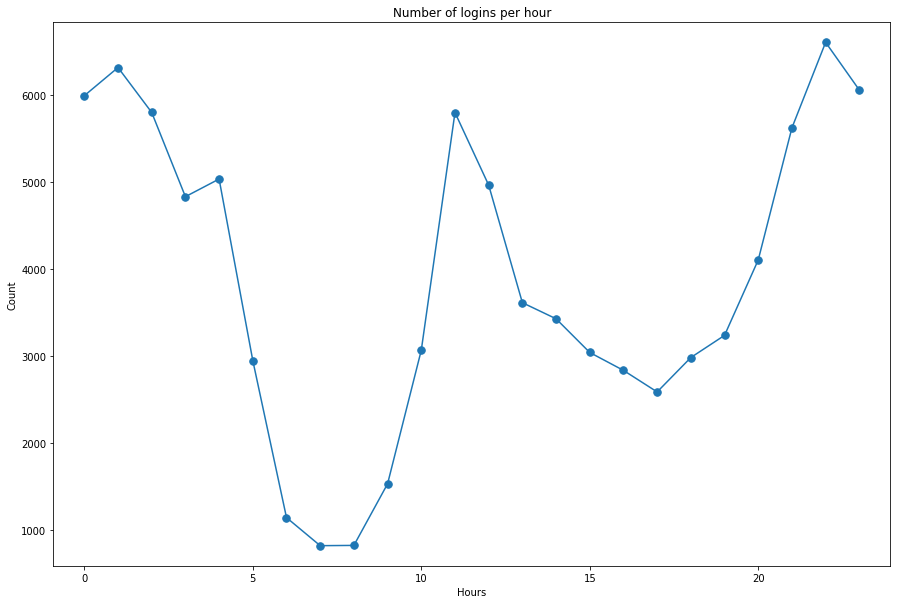

In [12]:
plt.figure(figsize=(15,10))
h = df['login_time'].dt.hour.value_counts().sort_index()
ax2 = h.plot(marker='.',markersize=15,visible=True)
plt.title('Number of logins per hour')
plt.xlabel('Hours')
plt.ylabel('Count')
plt.margins(0.04)

Looks really similar to the 15 minute interval. However, this would be the amount of logins per hour. The difference is that it peaks at night while in 15 minute intervals peaks during the afternoon. So it depends what is the best metric for the company. 

## 2. Experiment and metrics design <a name="metrics"></a>
***

**Problem**:
Currently, two-way toll, between the two cities causes driver partners to tend to be exclusive to each city.

**Info**
- On weekdays, City 1 active at night
- On weekdays, City 2 active during day
- On weekends, reasonable activity in both cities

**Experiment**
- Encourage driver partners to serve both cities by reimbursing all toll costs.

**Solution**

An important metric to keep track is the percentage of trips reimbursed per day. If there is a high percentage of reimbursement, this would mean drivers are taking advantage of the experiment and drivers would have easier access to both cities. 

Since the goal is to have drivers serve both cities, another important metric would be pickup location . This metric would track the city that the customer was picked up. If the experiment is successful, the driver should have substantial pickup locations in City 1 and 2. If it is not successful, drivers would remain serving mostly one City.

A simple way to test if reimbursing tolls is a success would be to do an A/B study. Select a percentage of drivers to participate in the test and allow them to serve both cities. After a given time if there is a trend that one group has a high percentage of reimbursement and higher pickup locations in both cities, it means the experiment is being successful.

## 3. Predictive modeling <a name="modeling"></a>
***

In [13]:
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
df.shape

(50000, 12)

In [15]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are 50,000 entries with 12 different columns. 

In [17]:
df.isnull().sum()/len(df)*100

avg_dist                   0.000
avg_rating_by_driver       0.402
avg_rating_of_driver      16.244
avg_surge                  0.000
city                       0.000
last_trip_date             0.000
phone                      0.792
signup_date                0.000
surge_pct                  0.000
trips_in_first_30_days     0.000
ultimate_black_user        0.000
weekday_pct                0.000
dtype: float64

There are some missing values of ratings and phone used. Let's fill out with the average for ratings. For the phone, let's first check which platform is used more than the other.

In [18]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

In [19]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Looks like users tend to have an iphone more than android. Since it is only a 0.79%, let's just fill the missing values with the highest phone used.

In [20]:
df['phone'].fillna('iPhone', inplace=True)

In [21]:
df.isnull().sum()/len(df)*100

avg_dist                  0.0
avg_rating_by_driver      0.0
avg_rating_of_driver      0.0
avg_surge                 0.0
city                      0.0
last_trip_date            0.0
phone                     0.0
signup_date               0.0
surge_pct                 0.0
trips_in_first_30_days    0.0
ultimate_black_user       0.0
weekday_pct               0.0
dtype: float64

Now that there are no missing values let's do some EDA to get a deeper understanding of the data.

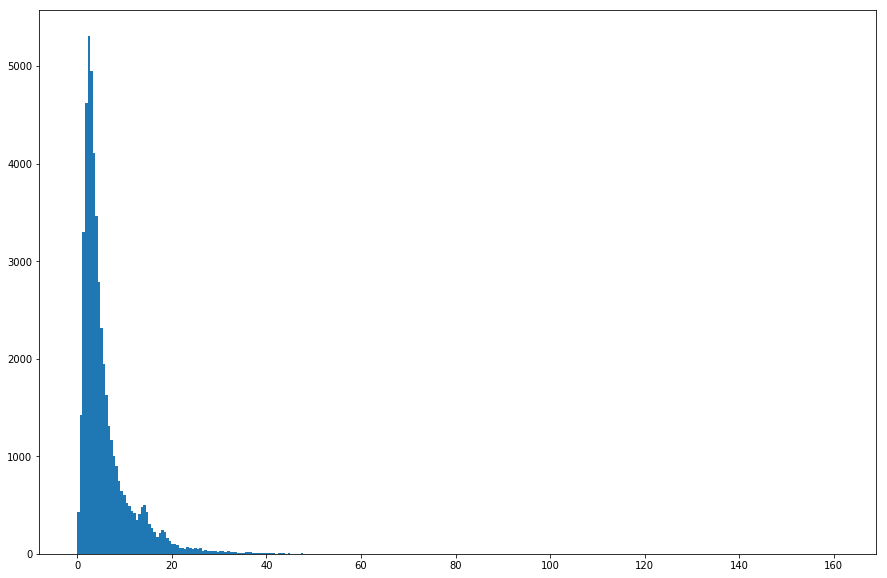

In [22]:
plt.figure(figsize=(15,10))
_ = plt.hist(df['avg_dist'].values,bins=300)

The average distance in miles per trip was less than 20 miles. 

In [23]:
trips_city = df[['trips_in_first_30_days', 'city']].groupby('city').sum().reset_index()
trips_city

,city,trips_in_first_30_days
0,Astapor,32219
1,King's Landing,24957
2,Winterfell,56734


Text(0.5,1,'Trips vs. City')

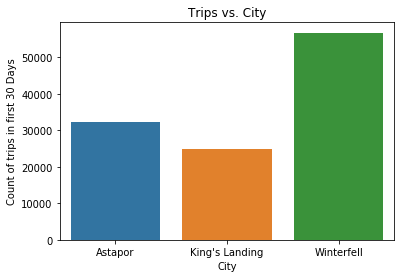

In [24]:
sns.barplot(x='city', y='trips_in_first_30_days', data=trips_city)
plt.ylabel('Count of trips in first 30 Days')
plt.xlabel('City')
plt.title('Trips vs. City')

Let's find out what was the last recorded date of the data. If the user has taken a trip in 6-months before our last recorded data point, they are considered a retained user.

In [25]:
df[['last_trip_date']].max()

last_trip_date    2014-07-01
dtype: object

In [26]:
print('Active users: {} \nNon-active users: {}'.format(len(df[df['last_trip_date'] >= '2014-06-01']),
                                                      len(df[df['last_trip_date'] < '2014-06-01'])))

Active users: 18804 
Non-active users: 31196


In [27]:
df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


In [28]:
print('Percentage of users retained: {}'.format((df['retained'].sum()/len(df)*100)))

Percentage of users retained: 37.608000000000004


The dataset is slightly unbalanced and for a more accurate prediction balancing is necessary. Now that we know the percentage of users retained let's prepare the data for doing the modeling.

In [29]:
df2 = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'],drop_first=True)
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,1.0,1,0,1,1
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,0.0,0,0,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,0.0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,1.0,1,0,1,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,0.0,0,1,0,0


In [30]:
# df2['last_trip_date'] = pd.to_datetime(df2['last_trip_date'], format='%Y-%m-%d')
# df2['signup_date'] = pd.to_datetime(df2['signup_date'], format='%Y-%m-%d') 

In [31]:
df2.drop(['signup_date','last_trip_date'], axis=1, inplace=True)

In [32]:
int_feat = df2.dtypes[(df2.dtypes != 'float64')].index
df2[int_feat] = df2[int_feat].astype(float)

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                    50000 non-null float64
avg_rating_by_driver        50000 non-null float64
avg_rating_of_driver        50000 non-null float64
avg_surge                   50000 non-null float64
surge_pct                   50000 non-null float64
trips_in_first_30_days      50000 non-null float64
weekday_pct                 50000 non-null float64
retained                    50000 non-null float64
city_King's Landing         50000 non-null float64
city_Winterfell             50000 non-null float64
phone_iPhone                50000 non-null float64
ultimate_black_user_True    50000 non-null float64
dtypes: float64(12)
memory usage: 4.6 MB


Now that all the columns are numerical values and converted to floats let's split our data in 70-30.

In [34]:
X = df2.drop('retained', axis=1)
y = df2['retained']

In [35]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='auto', kind='regular')
X, y = sm.fit_sample(X, y)

print('After balancing, the data increased from 50,000 to: {}'.format(len(y)))

After balancing, the data increased from 50,000 to: 62392


In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
scaled_features

array([[-0.36155338,  0.53366481,  0.17546446, ..., -0.93894487,
         0.61785552,  1.24088452],
       [ 0.4778417 ,  0.53366481,  0.7305533 , ..., -0.93894487,
        -1.66256744, -0.8371957 ],
       [-0.89189015,  0.53366481, -0.56465399, ..., -0.93894487,
         0.61785552, -0.8371957 ],
       ..., 
       [-0.1868187 ,  0.29676859,  0.7305533 , ...,  1.09754739,
         0.61785552, -0.8371957 ],
       [ 0.42795021,  0.2931011 , -0.64627618, ..., -0.48976551,
         0.61785552, -0.8371957 ],
       [ 3.63908996,  0.53366481, -0.56024546, ..., -0.93894487,
        -0.51627937, -0.8371957 ]])

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, y, test_size = 0.3, random_state = 42)

Let's try several algorithms and see which gives the best result.

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, f1_score

Using TensorFlow backend.


In [39]:
def results(X_test,y_test,y_pred,model):
    print("#####################")
    print("Test data")
    print("#####################")
    print("Model Accuracy: {:.2f}%".format(100*model.score(X_test, y_test)))
    print("#####################")
    print("F1 Score: ", f1_score(y_test, y_pred))
    print("#####################")
    print(classification_report(y_test, y_pred))
    print("#####################")
    conf_matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(conf_matrix, range(2),range(2))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, cmap='Blues',annot=True,annot_kws={"size": 36},fmt='g')

### Logistic Regression
***

In [40]:
param = {'C': [0.0001,0.001,0.01,0.1,1,10,100]}

log_cv = GridSearchCV(LogisticRegression(),param,cv=3,scoring='accuracy')
%time log_cv.fit(X_train,y_train)

CPU times: user 1.71 s, sys: 62.4 ms, total: 1.77 s
Wall time: 1.84 s


GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [41]:
%time y_pred = log_cv.predict(X_test)

print("Best Parameters: {}".format(log_cv.best_params_)) 
print("Best score is {}".format(log_cv.best_score_))

CPU times: user 1.13 ms, sys: 687 µs, total: 1.82 ms
Wall time: 859 µs
Best Parameters: {'C': 1}
Best score is 0.6985849704629756


#####################
Test data
#####################
Model Accuracy: 69.99%
#####################
F1 Score:  0.693512304251
#####################
             precision    recall  f1-score   support

        0.0       0.69      0.73      0.71      9297
        1.0       0.71      0.67      0.69      9421

avg / total       0.70      0.70      0.70     18718

#####################


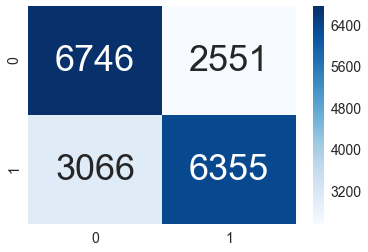

In [42]:
results(X_test,y_test,y_pred,log_cv)

### SVM
***

In [43]:
params = [
  {'C': [0.01,0.1,1, 10], 'kernel': ['linear']}
 ]

svm_cv = GridSearchCV(SVC(),params,cv=3,scoring='accuracy',verbose=3)
%time svm_cv.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=0.01, kernel=linear ...........................................
[CV] .. C=0.01, kernel=linear, score=0.7014218009478673, total=  27.6s
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34.8s remaining:    0.0s


[CV] ... C=0.01, kernel=linear, score=0.695493886522874, total=  25.6s
[CV] C=0.01, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] .. C=0.01, kernel=linear, score=0.6975338325204369, total=  22.4s
[CV] C=0.1, kernel=linear ............................................
[CV] .... C=0.1, kernel=linear, score=0.701078370767223, total=  26.2s
[CV] C=0.1, kernel=linear ............................................
[CV] ... C=0.1, kernel=linear, score=0.6956999587855475, total=  23.7s
[CV] C=0.1, kernel=linear ............................................
[CV] ... C=0.1, kernel=linear, score=0.6972590506285635, total=  23.2s
[CV] C=1, kernel=linear ..............................................
[CV] ...... C=1, kernel=linear, score=0.701078370767223, total=  33.1s
[CV] C=1, kernel=linear ..............................................
[CV] ...... C=1, kernel=linear, score=0.695493886522874, total=  34.6s
[CV] C=1, kernel=linear ..............................................
[CV] ..... C=1, kernel=linear, score=0.6970529642096586, total=  33.5s
[CV] C=10, kernel=linear .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 11.5min finished


CPU times: user 12min, sys: 8.54 s, total: 12min 8s
Wall time: 12min 16s


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [44]:
%time y_pred = svm_cv.predict(X_test)

print("Best Parameters: {}".format(svm_cv.best_params_)) 
print("Best score is {}".format(svm_cv.best_score_))

CPU times: user 6.54 s, sys: 66.8 ms, total: 6.61 s
Wall time: 6.6 s
Best Parameters: {'C': 0.01, 'kernel': 'linear'}
Best score is 0.698149929019554


#####################
Test data
#####################
Model Accuracy: 69.83%
#####################
F1 Score:  0.689161666758
#####################
             precision    recall  f1-score   support

        0.0       0.68      0.73      0.71      9297
        1.0       0.72      0.66      0.69      9421

avg / total       0.70      0.70      0.70     18718

#####################


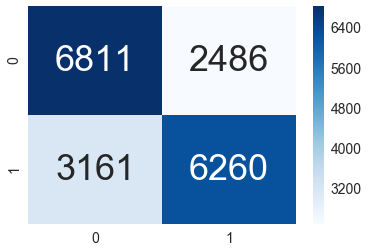

In [45]:
results(X_test,y_test,y_pred,svm_cv)

### Random Forests
***

In [46]:
params = {'max_features': ['auto'],
          'n_estimators': [5, 10, 15, 20]}

forest_cv = GridSearchCV(RandomForestClassifier(),params,cv=3,
                         scoring='accuracy',verbose=3)
%time forest_cv.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] max_features=auto, n_estimators=5 ...............................
[CV]  max_features=auto, n_estimators=5, score=0.7714815577992994, total=   0.2s
[CV] max_features=auto, n_estimators=5 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_features=auto, n_estimators=5, score=0.7710537161698036, total=   0.2s
[CV] max_features=auto, n_estimators=5 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  max_features=auto, n_estimators=5, score=0.775297107920588, total=   0.2s
[CV] max_features=auto, n_estimators=10 ..............................
[CV]  max_features=auto, n_estimators=10, score=0.782608695652174, total=   0.3s
[CV] max_features=auto, n_estimators=10 ..............................
[CV]  max_features=auto, n_estimators=10, score=0.7831432889133123, total=   0.3s
[CV] max_features=auto, n_estimators=10 ..............................
[CV]  max_features=auto, n_estimators=10, score=0.7861509926495844, total=   0.3s
[CV] max_features=auto, n_estimators=15 ..............................
[CV]  max_features=auto, n_estimators=15, score=0.7850813929528127, total=   0.5s
[CV] max_features=auto, n_estimators=15 ..............................
[CV]  max_features=auto, n_estimators=15, score=0.7907679626322297, total=   0.5s
[CV] max_features=auto, n_estimators=15 ..............................
[CV]  max_features=auto, n_estimators=15, score=0.7907535893384626, total=   0.5s
[CV

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    5.8s finished


CPU times: user 6.59 s, sys: 174 ms, total: 6.77 s
Wall time: 6.74 s


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto'], 'n_estimators': [5, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=3)

In [47]:
%time y_pred = forest_cv.predict(X_test)

print("Best Parameters: {}".format(forest_cv.best_params_)) 
print("Best score is {}".format(forest_cv.best_score_))

CPU times: user 94.5 ms, sys: 7.18 ms, total: 102 ms
Wall time: 100 ms
Best Parameters: {'max_features': 'auto', 'n_estimators': 20}
Best score is 0.7910885194852773


#####################
Test data
#####################
Model Accuracy: 79.68%
#####################
F1 Score:  0.796031107536
#####################
             precision    recall  f1-score   support

        0.0       0.79      0.81      0.80      9297
        1.0       0.80      0.79      0.80      9421

avg / total       0.80      0.80      0.80     18718

#####################


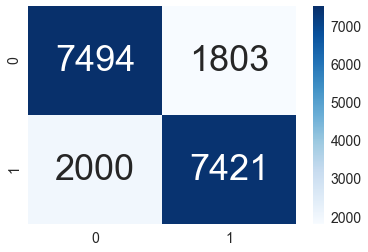

In [48]:
results(X_test,y_test,y_pred,forest_cv)

### Neural Network
***

In [49]:
n_cols = X_train.shape[1]
input_shape=(n_cols,)
y_train_matrix = to_categorical(y_train)
y_test_matrix = to_categorical(y_test)

In [50]:
def neural_network_results(y_test,y_pred):
    print("#####################")
    print("Test data")
    print("#####################")
    print(classification_report(y_test, y_pred))
    print("#####################")
    conf_matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(conf_matrix, range(2),range(2))
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, cmap='Blues',annot=True,annot_kws={"size": 36},fmt='g')

In [51]:
def build_model(optimizer):
    model = Sequential()
    model.add(Dense(8,activation='relu',input_shape = input_shape))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])
    return model

In [52]:
estimator = KerasClassifier(build_model)

In [53]:
params = {'epochs': [30],
          'optimizer': ['adam', 'rmsprop']}

keras_cv = GridSearchCV(estimator,params,cv=3)

In [54]:
%time keras_cv.fit(X_train,y_train_matrix)

Epoch 1/30
29116/29116 [==============================] - 3s 88us/step - loss: 0.6389 - acc: 0.6603
Epoch 2/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.5620 - acc: 0.7145
Epoch 3/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.5487 - acc: 0.7222
Epoch 4/30
29116/29116 [==============================] - 2s 85us/step - loss: 0.5384 - acc: 0.7310
Epoch 5/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.5317 - acc: 0.7353
Epoch 6/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.5272 - acc: 0.7389
Epoch 7/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.5234 - acc: 0.7428
Epoch 8/30
29116/29116 [==============================] - 2s 85us/step - loss: 0.5209 - acc: 0.7467
Epoch 9/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.5193 - acc: 0.7479
Epoch 10/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.5176 - acc: 0.7502

29116/29116 [==============================] - 2s 83us/step - loss: 0.4921 - acc: 0.7679
Epoch 21/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.4914 - acc: 0.7678
Epoch 22/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.4907 - acc: 0.7670
Epoch 23/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.4900 - acc: 0.7683
Epoch 24/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.4892 - acc: 0.7693
Epoch 25/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.4888 - acc: 0.7694
Epoch 26/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.4886 - acc: 0.7690
Epoch 27/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.4880 - acc: 0.7691
Epoch 28/30
29116/29116 [==============================] - 2s 84us/step - loss: 0.4875 - acc: 0.7701
Epoch 29/30
29116/29116 [==============================] - 2s 83us/step - loss: 0.4874 - acc: 0.7701
Ep

29116/29116 [==============================] - 2s 73us/step - loss: 0.5105 - acc: 0.7574
Epoch 8/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5090 - acc: 0.7575
Epoch 9/30
29116/29116 [==============================] - 2s 75us/step - loss: 0.5077 - acc: 0.7605
Epoch 10/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5061 - acc: 0.7614
Epoch 11/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5048 - acc: 0.7611
Epoch 12/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5039 - acc: 0.7620
Epoch 13/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5029 - acc: 0.7614
Epoch 14/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5020 - acc: 0.7637
Epoch 15/30
29116/29116 [==============================] - 2s 73us/step - loss: 0.5013 - acc: 0.7633
Epoch 16/30
29116/29116 [==============================] - 2s 72us/step - loss: 0.5007 - acc: 0.7641
Epoc

GridSearchCV(cv=3, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x108356b70>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epochs': [30], 'optimizer': ['adam', 'rmsprop']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [55]:
%time y_pred = keras_cv.predict(X_test)

print("Best Parameters: {}".format(keras_cv.best_params_)) 
print("Best score is {}".format(keras_cv.best_score_))

CPU times: user 335 ms, sys: 50.9 ms, total: 386 ms
Wall time: 294 ms
Best Parameters: {'epochs': 30, 'optimizer': 'rmsprop'}
Best score is 0.7667033017273979


#####################
Test data
#####################
             precision    recall  f1-score   support

        0.0       0.76      0.76      0.76      9297
        1.0       0.76      0.76      0.76      9421

avg / total       0.76      0.76      0.76     18718

#####################


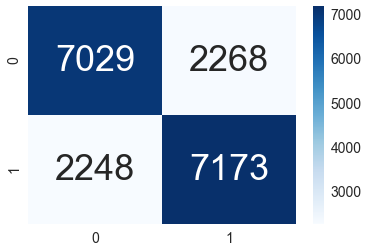

In [56]:
neural_network_results(y_test,y_pred)

### Results
***

In [58]:
d = {'Accuracy': {'SVM': '69.83%', 'Random Forest': '79.68%', 'Logistic Regression': '69.99%','NN(1 hidden layer,8 nodes)': '76.67%'}, 
     'Fitting Time': {'SVM': '12min 16s', 'Random Forest': '6.74s', 'Logistic Regression': '1.84s','NN(1 hidden layer,8 nodes)': '8min 34s'}, 
     'Prediction Time': {'SVM': '6.6 s', 'Random Forest': '100 ms', 'Logistic Regression': '1.82 ms', 'NN(1 hidden layer,8 nodes)': '294ms'}}
df = pd.DataFrame(d).reindex(index = ['Logistic Regression','SVM','Random Forest', 'NN(1 hidden layer,8 nodes)'])
df

,Accuracy,Fitting Time,Prediction Time
Logistic Regression,69.99%,1.84s,1.82 ms
SVM,69.83%,12min 16s,6.6 s
Random Forest,79.68%,6.74s,100 ms
"NN(1 hidden layer,8 nodes)",76.67%,8min 34s,294ms


### Conclusion
***
Decided to test 3 different classifiers and a neural network. At first, without balancing the data, the neural network with 1 hidden layer and 8 nodes was performing the better than the other techniques. After balancing the data using SMOTE, Random Forests did better than the other algorithms with an accuracy of **79.68%**. As well, it was a really quick computation that took only **6.74s** compared to the neural network that can be fitted to have better accuracy with more layers added to it. However, it would increase training time.

As we saw, most of the trips occur in Winterfell. A suggestion is to analyze deeper what is happening in that city to increase retention in other cities. As well, increase android users since most of users tend to be iphone. 